# Setup

In [1]:
# Get project folder
!git clone https://github.com/Survedog/MLTermProject.git project

Cloning into 'project'...
remote: Enumerating objects: 1011, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 1011 (delta 20), reused 32 (delta 10), pack-reused 966
Receiving objects: 100% (1011/1011), 69.23 MiB | 26.91 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [2]:
import pandas as pd
import numpy as np
pd.options.display.max_columns=100


# Load Data

In [3]:
answer_correct_data = pd.read_csv('project/data/train_data/train_task_3_4.csv', na_values='?')
answer_metadata = pd.read_csv('project/data/metadata/answer_metadata_task_3_4.csv', na_values='?')
question_metadata = pd.read_csv('project/data/metadata/question_metadata_task_3_4.csv', na_values='?')
student_metadata = pd.read_csv('project/data/metadata/student_metadata_task_3_4.csv', na_values='?')
subject_metadata = pd.read_csv('project/data/metadata/subject_metadata.csv', na_values='?')

In [4]:
answer_correct_data.head()

,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue
0,898,2111,280203,1,2,2
1,767,3062,55638,1,3,3
2,165,1156,386475,1,2,2
3,490,1653,997498,1,4,4
4,298,3912,578636,1,3,3


In [5]:
answer_metadata.head()

,AnswerId,DateAnswered,Confidence,GroupId,QuizId,SchemeOfWorkId
0,1451945,2019-10-30 14:34:00.000,NaN,4,32,52562.0
1,45325,2020-01-06 18:53:00.000,75.0,185,66,52562.0
2,687013,2020-01-18 10:52:00.000,NaN,235,64,52562.0
3,91254,2020-02-29 17:25:00.000,NaN,194,97,52562.0
4,1225855,2020-03-06 15:07:00.000,NaN,95,115,52562.0


In [6]:
question_metadata.head()

,QuestionId,SubjectId
0,684,"[3, 71, 98, 209]"
1,87,"[3, 71, 98, 209]"
2,679,"[3, 71, 98, 209]"
3,685,"[3, 71, 98, 209]"
4,222,"[3, 71, 98, 209]"


In [7]:
student_metadata.head()

,UserId,Gender,DateOfBirth,PremiumPupil
0,3837,2,2007-10-01 00:00:00.000,0.0
1,207,0,NaN,NaN
2,3581,2,2008-03-01 00:00:00.000,0.0
3,6028,2,2008-01-01 00:00:00.000,0.0
4,1451,0,NaN,NaN


In [8]:
subject_metadata.head()

,SubjectId,Name,ParentId,Level
0,3,Maths,NaN,0
1,32,Number,3.0,1
2,33,BIDMAS,144.0,3
3,34,Upper and Lower Bounds,141.0,3
4,35,Calculator Use,32.0,2


# Calculate feature values to measure question quality

In [9]:
# Integrate and group information for each question
answer_integrated = pd.merge(answer_correct_data, answer_metadata, 'inner', 'AnswerId')
answer_integrated_group = answer_integrated.groupby('QuestionId')
print(answer_integrated['AnswerValue'].value_counts())

3    384002
2    380878
1    338024
4    279823
Name: AnswerValue, dtype: int64


In [10]:
# Dataframe storing feature values
train_data = pd.DataFrame(columns=['CorrectRate', 'MeanConfidence', 'AnswerVariance'])
train_data.index.name = 'QuestionId'
train_data[['CorrectRate', 'MeanConfidence']] = answer_integrated_group.mean()[['IsCorrect', 'Confidence']]
train_data['AnswerVariance'] = answer_integrated_group.var()['AnswerValue']

<ipython-input-10-73b46ea1f961>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_data[['CorrectRate', 'MeanConfidence']] = answer_integrated_group.mean()[['IsCorrect', 'Confidence']]
<ipython-input-10-73b46ea1f961>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_data['AnswerVariance'] = answer_integrated_group.var()['AnswerValue']


In [11]:
# Replace NaN confidence values
print(train_data.isnull().sum())
print(answer_integrated[answer_integrated['QuestionId']==1].info())

# There is some questions that none of its answers have confidence info.
# -> Will set mean confidence as their confidence.
train_data['MeanConfidence'] = train_data['MeanConfidence'].fillna(train_data['MeanConfidence'].mean())
print(train_data.isnull().sum())

CorrectRate        0
MeanConfidence    44
AnswerVariance     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 6452 to 1291796
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   QuestionId      14 non-null     int64  
 1   UserId          14 non-null     int64  
 2   AnswerId        14 non-null     int64  
 3   IsCorrect       14 non-null     int64  
 4   CorrectAnswer   14 non-null     int64  
 5   AnswerValue     14 non-null     int64  
 6   DateAnswered    14 non-null     object 
 7   Confidence      0 non-null      float64
 8   GroupId         14 non-null     int64  
 9   QuizId          14 non-null     int64  
 10  SchemeOfWorkId  1 non-null      float64
dtypes: float64(2), int64(8), object(1)
memory usage: 1.3+ KB
None
CorrectRate       0
MeanConfidence    0
AnswerVariance    0
dtype: int64


# Preprocess feature values

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data_scaled = scaler.fit(train_data).transform(train_data)
train_data_scaled = pd.DataFrame(train_data_scaled, index=train_data.index, columns=train_data.columns)

# Validation

In [13]:
# Load validation data and submission template
validation_data = pd.read_csv('project/data/test_data/quality_response_remapped_public.csv', na_values='?')
template = pd.read_csv('project/submission/template.csv', na_values='?')

Use grid search to find best coefficients for each features.
**NOTE: This task can take a few minutes.**

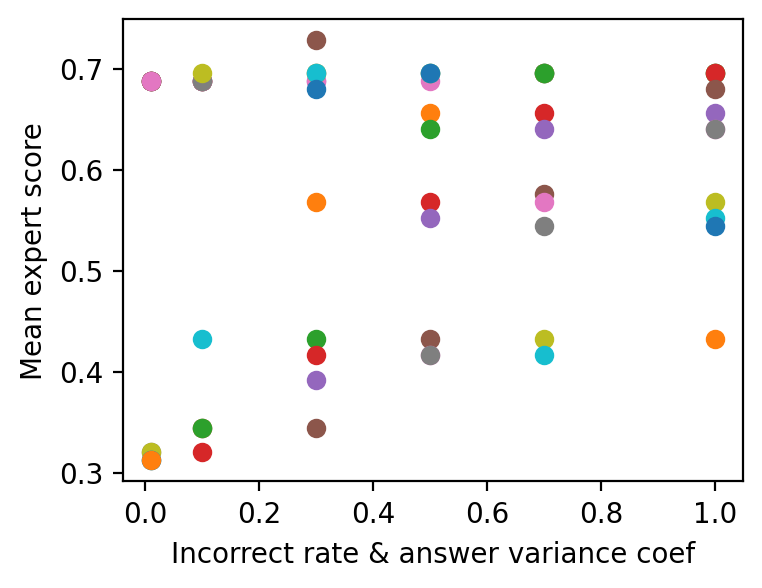

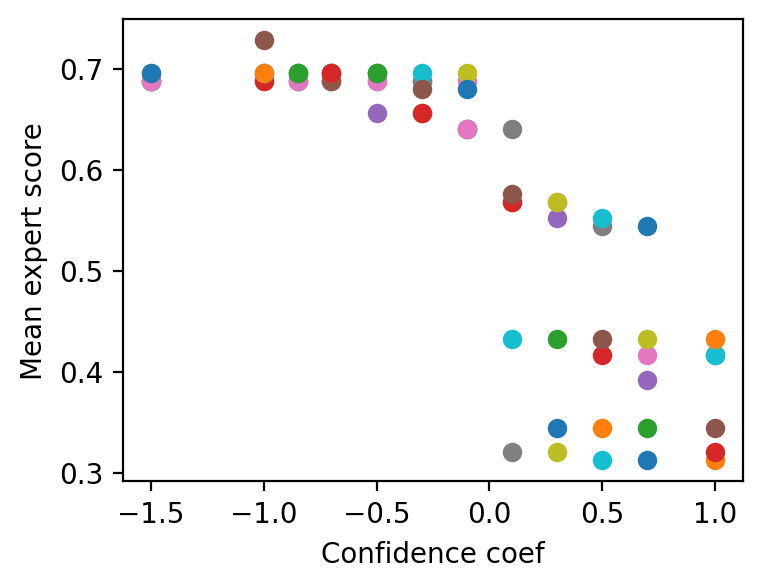

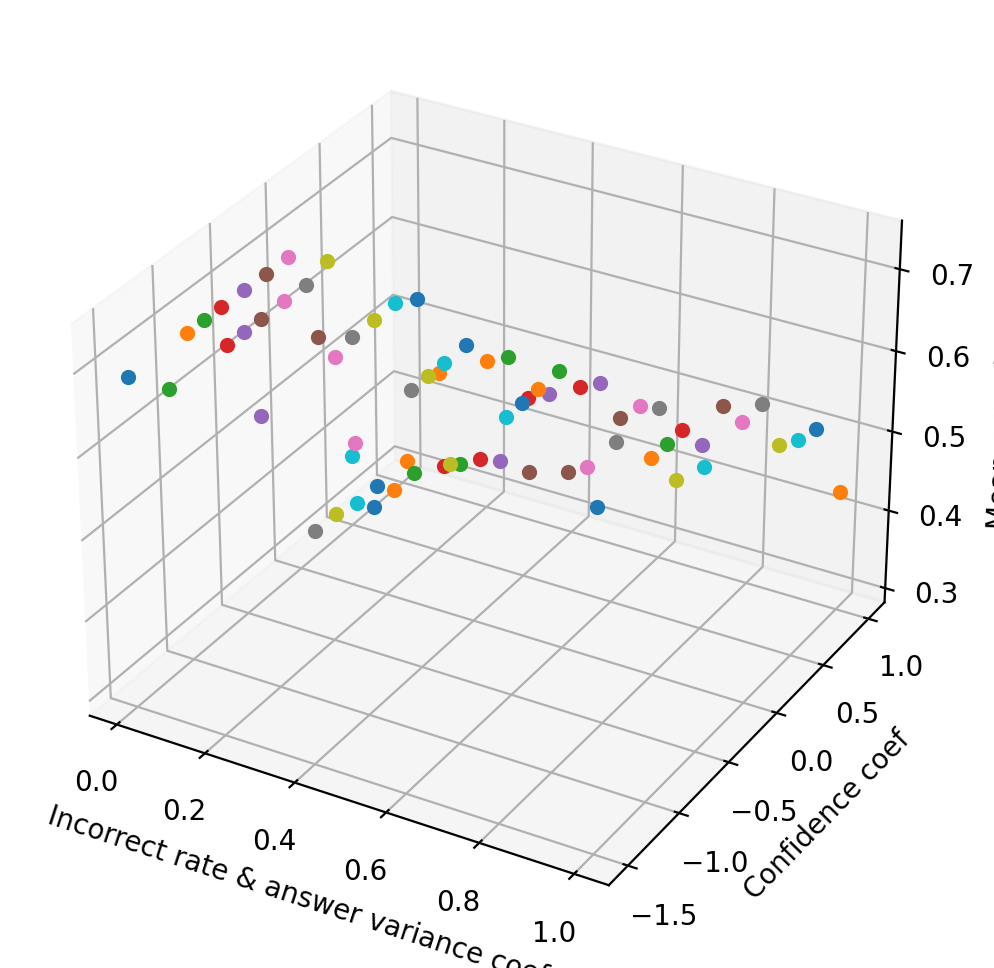

In [14]:
# For plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig1 = plt.figure(1, figsize=(4,3), dpi = 200)
plt.xlabel('Incorrect rate & answer variance coef')
plt.ylabel('Mean expert score')

fig2 = plt.figure(2, figsize=(4,3), dpi = 200)
plt.xlabel('Confidence coef')
plt.ylabel('Mean expert score')

fig3 = plt.figure(3, figsize=(8,6), dpi = 200)
ax = fig3.add_subplot(111, projection='3d')
ax.set_xlabel('Incorrect rate & answer variance coef', )
ax.set_ylabel('Confidence coef')
ax.set_zlabel('Mean expert score')

# Grid Search for finding best coefficients
best_score = 0.0
best_question_quality = pd.DataFrame(columns=['QualityMeasure', 'Rank'])

for incorrect_rate_answer_var_interaction_coef in [0.01, 0.1, 0.3, 0.5, 0.7, 1]:
    for confidence_coef in [-1.5, -1, -0.85, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7, 1]:

        # Measure quality
        question_quality = pd.DataFrame(columns=['QualityMeasure', 'Rank'])
        question_quality.index.name = 'QuestionId'

        for index in train_data_scaled.index:
            question_quality.loc[index] = \
                incorrect_rate_answer_var_interaction_coef \
                * (1 - train_data_scaled.at[index, 'CorrectRate']) \
                * train_data_scaled.at[index, 'AnswerVariance'] \
                + confidence_coef * train_data_scaled.at[index, 'MeanConfidence']

        # Calculate quality rank
        question_quality['Rank'] = question_quality['QualityMeasure'].rank(method='first', ascending=False)

        # Compare the quality of question pairs in validation data
        question_quality_compare = []
        for index in validation_data.index:
            left_question = validation_data.at[index, 'left']
            right_question = validation_data.at[index, 'right']
            question_quality_compare.append(1 if question_quality['Rank'][left_question] < question_quality['Rank'][right_question] else 2)

        # Score the result for each expert
        validation_scores = pd.Series([0.0, 0.0, 0.0, 0.0, 0.0])
        for index in validation_data.index:
            if question_quality_compare[index] == validation_data['T1_ALR'][index]:
                validation_scores[0] += 1
            if question_quality_compare[index] == validation_data['T2_CL'][index]:
                validation_scores[1] += 1
            if question_quality_compare[index] == validation_data['T3_GF'][index]:
                validation_scores[2] += 1
            if question_quality_compare[index] == validation_data['T4_MQ'][index]:
                validation_scores[3] += 1
            if question_quality_compare[index] == validation_data['T5_NS'][index]:
                validation_scores[4] += 1

        for expert in range(5):
            validation_scores[expert] = validation_scores[expert] / len(validation_data)

        # Calculate the mean expert correspondence score
        mean_score = validation_scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            best_question_quality = question_quality

        #  Plot the mean score with current coefficient values
        plt.figure(1)
        plt.scatter(incorrect_rate_answer_var_interaction_coef, mean_score)
        plt.figure(2)
        plt.scatter(confidence_coef, mean_score)
        plt.figure(3)
        ax.scatter(incorrect_rate_answer_var_interaction_coef, confidence_coef, mean_score)

plt.show()

In [15]:
# Show validation score
print("Max Validation Mean Score: {0}".format(best_score))

Max Validation Mean Score: 0.7280000000000001


In [16]:
# Write question ranks to csv file
best_question_quality = best_question_quality.astype(dtype={'QualityMeasure':'float64', 'Rank':'int64'})

for question_id in template['QuestionId']:
    template.at[question_id, 'ranking'] = best_question_quality.at[question_id, 'Rank']

template.to_csv('project/submission/20182632.csv', index=False)

# Get final test score

In [17]:
# Load test data
test_data = pd.read_csv('project/data/test_data/quality_response_remapped_private.csv', na_values='?')

In [18]:
# Compare each question pair in test data set
question_quality_compare = []
for index in test_data.index:
    left_question = test_data.at[index, 'left']
    right_question = test_data.at[index, 'right']
    question_quality_compare.append(1 if best_question_quality['Rank'][left_question] < best_question_quality['Rank'][right_question] else 2)

In [19]:
# Compare the result with each expert's decision and get score for each
test_scores = pd.Series([0.0, 0.0, 0.0, 0.0, 0.0])
for index in test_data.index:
    if question_quality_compare[index] == test_data['T1_ALR'][index]:
        test_scores[0] += 1
    if question_quality_compare[index] == test_data['T2_CL'][index]:
        test_scores[1] += 1
    if question_quality_compare[index] == test_data['T3_GF'][index]:
        test_scores[2] += 1
    if question_quality_compare[index] == test_data['T4_MQ'][index]:
        test_scores[3] += 1
    if question_quality_compare[index] == test_data['T5_NS'][index]:
        test_scores[4] += 1

for expert in range(5):
    test_scores[expert] = test_scores[expert] / len(test_data)

In [20]:
# Show validation score
print(test_scores)
print("Max Test Score: {0}".format(test_scores.max()))

0    0.72
1    0.60
2    0.60
3    0.60
4    0.80
dtype: float64
Max Test Score: 0.8
